In [ ]:
#default_exp peakmaps 

# Spatial versus spectral 

> Lasagna versus spaghetti  

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2 
%matplotlib notebook

In [ ]:
# hide 
import os
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

In [ ]:
#hide 
%matplotlib notebook

In the previous sections we have converted and calibrated the original `.raw` spectral image data file into an analysis ready `.datastack` file. We will now gently start to learn how this three dimensional data cube is structured. Basically there are two ways to look at this data. One perspective is to think of the data cube as a stack of gray scale images. Every image has a different energy associated with it. If you remember from the previous section, these energies are the x-ray photon energies, expressed in kilo electron Volts (keV). Each image in the stack contains a distribution of intensities (photon counts). This is the lasagna view. 

Another way to think of the same data cube is to describe it as a rectangular bundle of spectra. At each spatial *(x,y)* location the data cube contains a spectrum with varying intensity along the third dimension *(z)* of the cube. This is the spaghetti view. 

Very roughly speaking, the spatial intensity distribution within a slice located at a specific peak energy represents the spatial distribution of a certain chemical element. Without prior knowledge of XRF physics (we will get to this topic later on) we can compute peak slice maps for all peaks in the max spectrum. 

The computation of peak slices and peak slice maps from the data cube can be done with the `plot_peak_slices()`and `get_peakmaps()` functions. 

<IPython.core.display.Javascript object>


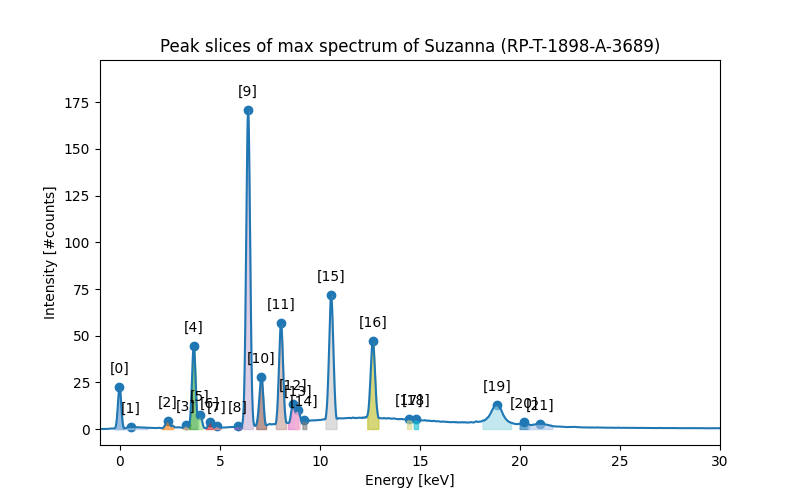

In [ ]:
from maxrf4u import DataStack, plot_peak_slices, get_peakmaps 

ds = DataStack('RP-T-1898-A-3689.datastack') 

x_keVs = ds.read('maxrf_energies')
y_max = ds.read('maxrf_maxspectrum')

fig, ax = plot_peak_slices(x_keVs, y_max)

ax.set_xlim([-1, 30])
ax.set_xlabel('Energy [keV]')
ax.set_ylabel('Intensity [#counts]')
ax.set_title('Peak slices of max spectrum of Susanna (RP-T-1898-A-3689)');

Altogether we see that 22 peaks have been detected. The largest peak no. 9 is located at an energy of 6.40 keV and is caused by the x-ray fluorescence of iron in the drawing. We can now compute the corresponding peak slice maps using the `get_peakmaps()` function. 

In [ ]:
arr = ds.read('maxrf_cube', compute=False)  
peak_maps, keV_maps = get_peakmaps(arr, x_keVs, y_max) 

In [ ]:
FeKa_map = peak_maps[9]

<IPython.core.display.Javascript object>


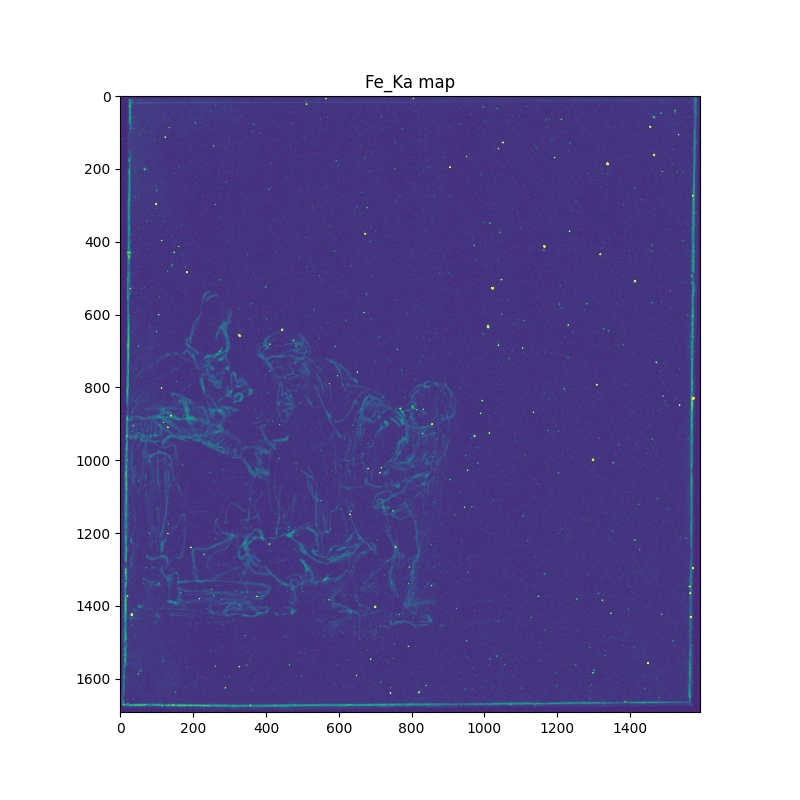

In [ ]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=[8, 8])
ax.imshow(FeKa_map, vmax=0.04);
ax.set_title('Fe_Ka map');

We see here the distribution of iron associated with the iron-gall ink that Rembrandt used, as well as bright yellow speckles caused by iron particles present in the paper background. 

Now, let's compare the iron distribution map with a photo of the drawing. In order to make such a comparison we need to register the two images. Automated registration of images is a very important capability that is unfortunately out of scope here. Instead I have created a four point warping function `warp()` that will do the job if we provide the corresponding corner points of both the source and destiny image.  

In [ ]:
from maxrf4u import warp, append  
import numpy as np 

susanna_highres_file = '/home/frank/Work/Projecten/DoRe/data/drawings/rma-web-highres/RP-T-1898-A-3689_highres.png'
susanna_highres = plt.imread(susanna_highres_file)

im_src = susanna_highres
im_dst = peak_maps[9] # Fe_Ka 

# corner points for image registration 
pts_src = np.array([[78.5, 204.6], [4340.1, 180.4], [4374.9, 4724.9], [110.1, 4766.3]])
pts_dst = np.array([[24.7, 7.64], [1579.0, 10.2], [1563.8, 1666.0], [8.22, 1671.92]])

im_vis_reg_highres, extent = warp(im_src, im_dst, pts_src, pts_dst, rgba=False)
im_vis_reg, extent = warp(im_src, im_dst, pts_src, pts_dst, keep_scale=False, rgba=False)

For future calculations we will store the registered images and their extent in our `.datastack` file. 

In [ ]:
#hide 

append(im_vis_reg, 'im_vis_reg', 'RP-T-1898-A-3689.datastack')
append(im_vis_reg_highres, 'im_vis_reg_highres', 'RP-T-1898-A-3689.datastack')
append(extent, 'im_vis_extent', 'RP-T-1898-A-3689.datastack')

ds = DataStack('RP-T-1898-A-3689.datastack')

extent = ds.read('im_vis_extent')
im_vis_reg_highres = ds.read('im_vis_reg_highres')

<IPython.core.display.Javascript object>


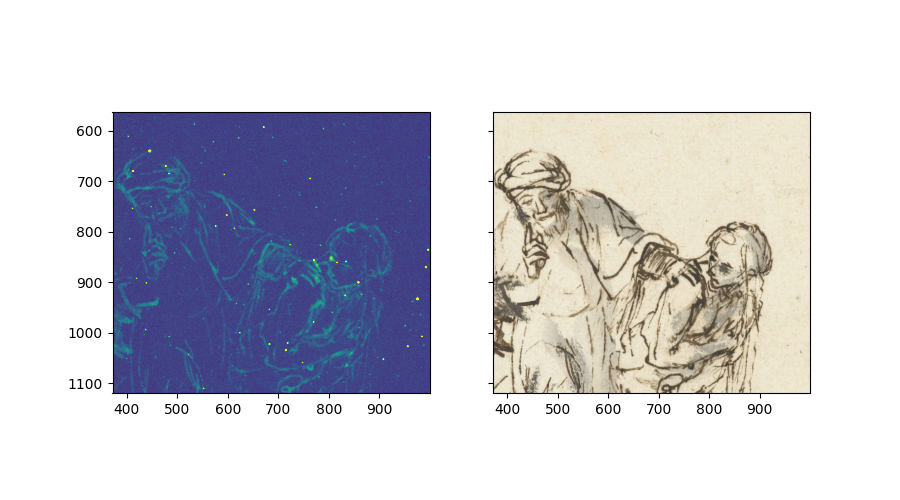

In [ ]:
#hide_input 
fig, [ax, ax1] = plt.subplots(ncols=2, figsize=[9, 5], sharex=True, sharey=True)

ax.imshow(peak_maps[9], vmax=0.03)
ax1.imshow(im_vis_reg_highres, extent=extent);

In [ ]:
#export 

import scipy.signal as ssg 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import cv2 


def get_slices(x_calib, y_max, prominence=0.5, rel_height=0.2):  
    '''Returns: *peaks_xy*, *slices*'''

    # peak positions and properties 
    peak_indices, shapes_dict = ssg.find_peaks(y_max, prominence=prominence)
    peaks_x, peaks_y = x_calib[peak_indices], y_max[peak_indices]
    ip_widths, heights, left_ips, right_ips = ssg.peak_widths(y_max, peak_indices, rel_height=rel_height) 

    # estimate peak bases 2 x 2 x width at rel_height 0.2  
    dx = x_calib[1] - x_calib[0]
    left_bases = peaks_x -  2 * dx * ip_widths
    right_bases = peaks_x +  2 * dx * ip_widths 

    # find nearest index positions 
    left_bases_idx = np.array([np.argmin((x_calib - lb)**2) for lb in left_bases]) 
    right_bases_idx = np.array([np.argmin((x_calib - rb)**2) for rb in right_bases]) 

    # combine 
    peaks_xy = np.c_[peaks_x, peaks_y]
    slices = np.c_[left_bases_idx, peak_indices, right_bases_idx]
    
    return peaks_xy, slices



def get_peakmaps(arr, x_calib, y_max, prominence=0.5, rel_height=0.2, norm=True): 
    '''Integrate peak slices into peak maps and keV maps. 
    
    Returns: peak_maps, keV_maps'''
    
    peaks_xy, slices = get_slices(x_calib, y_max, prominence=prominence, rel_height=rel_height)

    peak_maps = []
    keV_maps = []

    for i, [si, sj, sk] in enumerate(slices): 
        
        print(f'{i}/{len(slices)}', end='\r')
    
        peak_slice = arr[:,:,si:sk+1].compute()
        d = sk - si 
        
        peak_map = np.sum(peak_slice, axis=2) / d - (peak_slice[:,:,0] + peak_slice[:,:,-1]) / 2 
        
        if norm:  
            peak_map = peak_map / peak_map.max()
            # no clipping to study better the low signal noise 
            # peak_map = np.clip(peak_map, a_min=0, a_max=1)
        
        keV_idx_map = si + np.argmax(peak_slice, axis=2)
        keV_map = x_calib[keV_idx_map]

        peak_maps.append(peak_map) 
        keV_maps.append(keV_map)
        
    return peak_maps, keV_maps 



def plot_peak_slices(x_calib, y_max, ax=None, prominence=0.5, rel_height=0.2, 
                     grid=False, labels='simple', figsize=[8, 5]): 
    '''Utility function to plot the results of get_slices()'''
    
    peaks_xy, slices = get_slices(x_calib, y_max, prominence=prominence, rel_height=rel_height)
    zero = np.zeros_like(x_calib) 

    if ax is None: 
        fig, ax = plt.subplots(figsize=figsize)    
    else: 
        fig = ax.get_figure()
        
    ax.plot(x_calib, y_max)
    
    if labels is 'simple': 
        peak_labels = [f'[{i}]' for i in range(len(peaks_xy))]    
    elif labels is 'full': 
        peak_labels = [f'[{i}]\n{keV:.03f}keV' for i, [keV, _] in enumerate(peaks_xy)]    
    else: 
        assert False, 'Option labels=  can be "simple" or "full"'        

    [ax.annotate(s, xy, xytext=(0, 10), ha='center', textcoords='offset points') for s, xy in zip(peak_labels, peaks_xy)]

    ax.scatter(*peaks_xy.T)
    if grid: 
        ax.grid()

    # colorize peak slices 
    n_slices = len(slices) 
    colors = cm.tab20(np.arange(n_slices) % 20)
    
    
    [ax.fill_between(x_calib, zero, y_max, alpha=0.6, color=color, 
                     where=np.r_[np.zeros(i), np.ones(k - i), np.zeros(len(x_calib) - k)]) 
     for [i, j, k], color in zip(slices, colors)];
    
    # expand to avoid label clipping 
    y0, y1 = ax.get_ylim()
    ax.set_ylim([y0, 1.1 * y1])
    
    return fig, ax 


def warp(im_src, im_dst, pts_src, pts_dst, keep_scale=True, rgba=True, alpha_color=[1, 0, 0]): 
    '''Opencv based homographic registration. Can return transparent overlay (rgba). 
    
    Returns: *im_warped*, *extent* '''

    src_h, src_w = im_src.shape[0:2]
    dst_h, dst_w = im_dst.shape[0:2]
    
    if keep_scale: 
        scale = src_h / dst_h 
    else: 
        scale = 1

    # calculate homography 
    hom, status = cv2.findHomography(pts_src, scale * pts_dst)

    # Size is nearest integer scaled (width,height) of im_dst
    size = round(scale * dst_w), round(scale * dst_h)
    
    # warp im_src onto destination 
    im_warped = cv2.warpPerspective(im_src, hom, size) 
    
    # warp white onto destination to create mask 
    mask_src = np.ones([src_h, src_w])
    mask_warped = cv2.warpPerspective(mask_src, hom, size) 
    
    # calculate extent for plotting 
    h, w = im_dst.shape[0:2] 
    extent =  (0, w, h, 0) 
    
    # convert into rgba image  
    if rgba is True: 
        im_rgba = np.ones([h, w, 4])

        # for single channel image 
        if len(im_src.shape) == 2:
            # colorize
            im_rgba[:,:,0:3] = alpha_color[0:3] 
            #  make alpha layer 
            im_rgba[:,:,3] = im_warped 
            
        # otherwise assume image is rgb
        elif len(im_warped.shape) == 3: 
            
            # rgb channels
            im_rgba[:,:,0:3] = im_warped[:,:,0:3]
            # alpha channels 
            im_rgba[:,:,3] = mask_warped
       
        im_warped = im_rgba 
    
    return im_warped, extent  